
[1]输入数据 [2]查看报告与K线 [3]退出: 2

最新分析报告 (2026-01-31):
RSI: 57.63 | 信号: 无
预测结论: ⚖️ 震荡 (趋势不明)


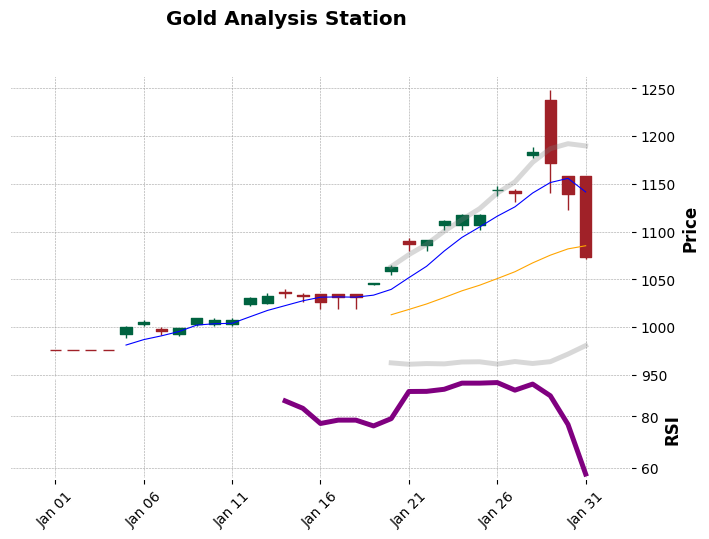


[1]输入数据 [2]查看报告与K线 [3]退出: 3


In [2]:
import pandas as pd
import os
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import datetime

# 配置文件
DB_FILE = "gold_data_sge.csv"

class GoldProStation:
    def __init__(self):
        self.df = self.load_data()

    def load_data(self):
        """加载数据，如果不存在则创建含表头的空文件"""
        if os.path.exists(DB_FILE):
            df = pd.read_csv(DB_FILE, index_col=0, parse_dates=True)
            return df
        else:
            # 创建包含标准OHLC格式的表头
            df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close'])
            df.set_index('Date', inplace=True)
            df.to_csv(DB_FILE)
            print(f"📢 已创建空数据库: {DB_FILE}，请手动填入数据或通过程序输入。")
            return df

    def add_entry(self):
        """交互式输入每日数据"""
        date_str = input("请输入日期 (YYYY-MM-DD, 直接回车为今天): ")
        if not date_str: date_str = datetime.now().strftime('%Y-%m-%d')
        
        try:
            o = float(input("开盘价 (Open): "))
            c = float(input("收盘价 (Close): "))
            # 如果不想查最高/最低，暂以开收盘的极值代替，但建议输入实测值
            h = input("最高价 (High, 回车自动取开收盘最大值): ")
            h = float(h) if h else max(o, c)
            l = input("最低价 (Low, 回车自动取开收盘最小值): ")
            l = float(l) if l else min(o, c)
            
            new_data = pd.DataFrame([[o, h, l, c]], 
                                    columns=['Open', 'High', 'Low', 'Close'],
                                    index=[pd.to_datetime(date_str)])
            self.df = pd.concat([self.df, new_data])
            self.df = self.df[~self.df.index.duplicated(keep='last')].sort_index()
            self.df.to_csv(DB_FILE)
            print("✅ 记录已保存。")
        except ValueError:
            print("❌ 输入有误，请输入数字。")

    def analyze(self):
        """计算指标并给出预测"""
        if len(self.df) < 5:
            print("⚠️ 数据不足，无法分析。")
            return

        df = self.df.copy()
        # 1. 均线
        df['MA5'] = df['Close'].rolling(5).mean()
        df['MA20'] = df['Close'].rolling(20).mean()
        
        # 2. 布林带
        df['STD'] = df['Close'].rolling(20).std()
        df['Upper'] = df['MA20'] + (df['STD'] * 2)
        df['Lower'] = df['MA20'] - (df['STD'] * 2)

        # 3. RSI (14) 计算
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / (loss + 1e-9)
        df['RSI'] = 100 - (100 / (1 + rs))

        # 4. 底背离逻辑
        # 价格创5日新低但RSI未创5日新低
        df['Price_Low'] = df['Close'].rolling(5).min()
        df['RSI_Low'] = df['RSI'].rolling(5).min()
        bottom_div = (df['Close'].iloc[-1] <= df['Price_Low'].iloc[-1]) and \
                     (df['RSI'].iloc[-1] > df['RSI_Low'].iloc[-1]) and (df['RSI'].iloc[-1] < 40)

        # 预测逻辑
        last = df.iloc[-1]
        prediction = ""
        if last['RSI'] < 30 or bottom_div: prediction = "🛡️ 见底 (超卖/底背离)"
        elif last['RSI'] > 70 or (not pd.isna(last['Upper']) and last['Close'] >= last['Upper']): 
            prediction = "🚨 见顶 (超买/压力位)"
        elif last['MA5'] > last['MA20'] and last['Close'] > last['MA20']: prediction = "📈 预期稳定上升"
        elif last['MA5'] < last['MA20'] and last['Close'] < last['MA20']: prediction = "📉 预期稳定下降"
        else: prediction = "⚖️ 震荡 (趋势不明)"

        print(f"\n最新分析报告 ({df.index[-1].strftime('%Y-%m-%d')}):")
        print(f"RSI: {last['RSI']:.2f} | 信号: {'【底背离】' if bottom_div else '无'}")
        print(f"预测结论: {prediction}")

        # 5. 绘图 (蜡烛图 + 均线 + RSI)
        # 定义RSI副图
        add_plots = [
            mpf.make_addplot(df['MA5'], color='blue', width=0.8),
            mpf.make_addplot(df['MA20'], color='orange', width=0.8),
            mpf.make_addplot(df['RSI'], panel=1, color='purple', ylabel='RSI')
        ]
        
        if not pd.isna(last['Upper']):
            add_plots.append(mpf.make_addplot(df[['Upper', 'Lower']], color='gray', alpha=0.3))

        mpf.plot(df, type='candle', style='charles', 
                 title='Gold Analysis Station',
                 ylabel='Price',
                 addplot=add_plots,
                 main_panel=0, 
                 panel_ratios=(3,1), # 主图与副图比例
                 figratio=(12,8))

def main():
    station = GoldProStation()
    while True:
        cmd = input("\n[1]输入数据 [2]查看报告与K线 [3]退出: ")
        if cmd == '1': station.add_entry()
        elif cmd == '2': station.analyze()
        elif cmd == '3': break

if __name__ == "__main__":
    main()